In [1]:
import numpy as np
import pandas as pd
import datetime
from tqdm import tqdm 
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore')

In [2]:
def baoluoxian(data,n,m):
    sma_n = pd.Series(np.convolve(data["close"], np.ones(n) /n, 'valid'),index=data.index[n-1:len(data["close"])])
    # df_1['date'] = df_date['dates'][119:28896]
    # df_1 = np.convolve(df["closing_prices"], np.ones(60) / 60, 'valid')[60:28896]
    sma_m = pd.Series(np.convolve(data["close"], np.ones(m) / m, 'valid'),index=data.index[m-1:len(data["close"])])
    
    max_diff=[]
    for high, low, close in zip(data["high"], data["low"], data["close"].shift(1)):
        max_diff.append(max(high-low,high-close,close-low))#data["high"].values-data.shift(1)["close"].values,data.shift(1)["close"].values-data["low"].values)
    df_tmp = pd.DataFrame(max_diff,index=data.index)
    df_tmp1 = pd.concat([sma_n,sma_m,df_tmp],axis=1)
    df_tmp1.columns =["sma_n","sma_m","max_diff"]
    
    df_sma = pd.concat([data,df_tmp1],axis=1)
    
    return df_sma

In [10]:
def up_down_max(data,n,m,N1,N2):
    data["up_max"]=None
    data["down_max"]=None
    for i in range(m+N1-2,len(data['close'])):
        up_max=max(data["sma_n"][i-(N1-1):i+1].max(),data["sma_m"][i-(N1-1):i+1].max())
        down_max=min(data["sma_n"][i-(N1-1):i+1].min(),data["sma_m"][i-(N1-1):i+1].min())
        data["up_max"][i]=up_max
        data["down_max"][i]=down_max
    data["diff_min"] = data['max_diff'].rolling(N2).min()
    
    return data

In [4]:
def calc_signal(data, m,N1, N2, alpha, default_af , stepsize_af, max_af):
    """ 计算信号 """
    
    data['signal']=None
    data["stop_price"]=None
    data['stop or not']=False
    direction =None
    stop_price=None
    
    for i in range(m+N1-2,len(data['close'])):
        
        if direction is None: # 计算开仓方向
            if data["close"][i]>data["up_max"][i] and data["close"][i-1]<data["up_max"][i-1] and data["diff_min"][i] < alpha:
                #上穿
                direction =1
                stop_price = data["low"][i]
                data["stop_price"][i]=stop_price
                highest_price = data["high"][i]
                af = default_af
                data['signal'][i] = direction
            elif data["close"][i]<data["down_max"][i] and data["close"][i-1]>data["down_max"][i-1] and data["diff_min"][i] < alpha:
                #下穿
                direction = -1
                stop_price=data["high"][i]
                data["stop_price"][i]=stop_price
                lowest_price = data["low"][i]
                af = default_af
                data['signal'][i] = direction
#             data['signal'][i] = direction
        else:
            if direction == 1 :
                # 已多头入场
                
                #先看当期要不要止损
                if data["low"][i] -stop_price <= 0:
                    #平仓
                    direction = None
                    data['signal'][i] = 0
                    data['stop or not'][i]=True
                
                #再设置止损价格
                if data["high"][i]>highest_price: # 创新高
                    highest_price=data["high"][i]
                    af +=stepsize_af
                    af = af if af <= max_af else max_af
                stop_price = stop_price + (highest_price-stop_price) * af
                data["stop_price"][i]=stop_price

                    
            elif direction == -1 :
                # 已空头入场
                
                #先看当期要不要止损
                if stop_price -data["high"][i]  <= 0:
                    #平仓
                    direction = None
                    data['signal'][i] = 0
                    data['stop or not'][i]=True
                
                #再设置止损价格
                if data["low"][i]<lowest_price: # 创新低
                    lowest_price=data["low"][i]
                    af +=stepsize_af
                    af = af if af<=max_af else max_af
                stop_price = stop_price - (stop_price-lowest_price) * af
                data["stop_price"][i]=stop_price
                
    return data  
                   

In [5]:
#持仓计算
def calc_position(data, shift_period=1, otime_limit=None, etime_limit=None):
    """ signal -> position """
    signal = data['signal']
    position = signal.fillna(method='ffill').shift(shift_period).fillna(0)
    
    """ 是否每天otime前空仓 """
    if otime_limit:
        position[data['time']<=otime_limit]=0
    """ 是否每天etime后空仓 """
    if etime_limit:
        position[data['time']>etime_limit]=0
    data['position'] = position
    return data

In [21]:
def statistic_performance(data, r0=0.03, data_period=1440, 
                          is_consider_open=True,
                          is_daily_close = False,
                          comm=None, leverage=None):
    position = data['position']
    close = data['close']
#     open_p = data['open']
    
    d_first = data['date'].values[0]
    d_last = data['date'].values[-1]
    d_period = datetime.datetime.strptime(d_last, '%Y-%m-%d') - datetime.datetime.strptime(d_first, '%Y-%m-%d')
    y_period = d_period.days / 365

    """      序列型特征 
        hold_r :      持仓收益
        hold_win :    持仓胜负
        hold_cumu_r : 累计持仓收益
        drawdown :    回撤
        ex_hold_r :   超额收益
    """
    """ 默认配置 
        period_in_price：前一日收盘价
        period_out_price：当日收盘价 
    """
    
    """ 每期的持仓收益hold_r是计算的第一个序列，也是后续统计的核心 
        hold_r = hold_out_price/hold_in_price - 1
    """
    # 1. 先初始化
    hold_in_price =  close.shift(1).copy()
    hold_in_price[close.index[0]] = close.values[0]
    hold_out_price = close.copy()
    #考虑止损
    
    #不考虑跳空 直接把出场价设成止损价
#     hold_out_price[data['stop or not']] = data['stop_price'].shift(1) 
    
    #考虑跳空 比较止损价和开盘价
    for i in range(1,len(data['close'])):
        if data["position"][i]<0 and data['stop or not'][i] == True:

            hold_out_price[i] = max(data['stop_price'][i-1],data['open'][i])
            
        elif data["position"][i]>0 and data['stop or not'][i] == True:
            hold_out_price[i] = min(data['stop_price'][i-1],data['open'][i])
    
    # 2. 若考虑持仓信号第二天开盘才能操作
    if is_consider_open:
        # 仓位变动第一期的period_in_price为当日open
        hold_in_price[abs(position - position.shift(1).fillna(0))>0] = open_p
        # 仓位变动前最后一期的period_out_price为第二日open (除了整个序列最后一天不变)
        hold_out_price[abs(position - position.shift(-1).fillna(0))>0] = open_p.shift(-1)
        hold_out_price[hold_out_price.index[-1]] = close.values[-1]
    
    #3.是否收盘前平仓
    if is_daily_close:
        daily_last_idxes = data.drop_duplicates(subset='date',keep='last').index
        hold_out_price.loc[daily_last_idxes.values] = close
    
    # 4. 计算 hold_r = position * (period_out_price/period_in_price - 1)
    hold_r = position * ((hold_out_price)/(hold_in_price)-1)
    
    # 5. 若考虑换仓成本 
    if comm:
        chgpos_comm_perc = (1-comm)**abs(position - position.shift(1).fillna(0)) 
        hold_r = chgpos_comm_perc * (1+hold_r) - 1 
        
    # 6. 若考虑杠杆 
    if leverage:
        hold_r *= leverage

    hold_win = hold_r>0
    hold_cumu_r = (1+hold_r).cumprod() - 1
    drawdown = (hold_cumu_r.cummax()-hold_cumu_r)/(1+hold_cumu_r).cummax()    
    ex_hold_r= hold_r-r0/(250*1440/data_period)
    
    data['hold_in_price'] = hold_in_price *abs(position)
    data['hold_out_price'] = hold_out_price *abs(position)
    data['hold_r'] = hold_r
    data['hold_win'] = hold_win
    data['hold_cumu_r'] = hold_cumu_r
    data['drawdown'] = drawdown
    data['ex_hold_r'] = ex_hold_r
    
    """       数值型特征 
        v_hold_cumu_r：         累计持仓收益
        v_pos_hold_times：      多仓开仓次数
        v_pos_hold_win_times：  多仓开仓盈利次数
        v_pos_hold_period：     多仓持有周期数
        v_pos_hold_win_period： 多仓持有盈利周期数
        v_neg_hold_times：      空仓开仓次数
        v_neg_hold_win_times：  空仓开仓盈利次数
        v_neg_hold_period：     空仓持有盈利周期数
        v_neg_hold_win_period： 空仓开仓次数
        
        v_hold_period：         持仓周期数（最后一笔未平仓订单也算）
        v_hold_win_period：     持仓盈利周期数（最后一笔未平仓订单也算）
        
        v_max_dd：              最大回撤
        v_annual_std：          年化标准差
        v_annual_ret：          年化收益
        v_sharpe：              年化夏普
    """
    v_hold_cumu_r = hold_cumu_r.tolist()[-1]

    v_pos_hold_times= 0 
    v_pos_hold_win_times = 0
    v_pos_hold_period = 0
    v_pos_hold_win_period = 0
    v_neg_hold_times= 0 
    v_neg_hold_win_times = 0
    v_neg_hold_period = 0
    v_neg_hold_win_period = 0
    for w, r, pre_pos, pos in zip(hold_win, hold_r, position.shift(1), position):
        """ 当日有换仓（先结算上一次持仓，再初始化本次持仓） """
        if pre_pos!=pos: 
            # 判断pre_pos非空：若为空则是循环的第一次，此时无需结算，直接初始化持仓即可
            if pre_pos == pre_pos:
                # 结算上一次持仓
                if pre_pos>0:
                    v_pos_hold_times += 1
                    v_pos_hold_period += tmp_hold_period
                    v_pos_hold_win_period += tmp_hold_win_period
                    if tmp_hold_r>0:
                        v_pos_hold_win_times+=1
                elif pre_pos<0:
                    v_neg_hold_times += 1      
                    v_neg_hold_period += tmp_hold_period
                    v_neg_hold_win_period += tmp_hold_win_period
                    if tmp_hold_r>0:                    
                        v_neg_hold_win_times+=1
            # 初始化本次持仓
            tmp_hold_r = r
            tmp_hold_period = 0
            tmp_hold_win_period = 0
        else: 
            if abs(pos)>0:
                tmp_hold_period += 1
                if r>0:
                    tmp_hold_win_period += 1
                if abs(r)>0:
                    tmp_hold_r = (1+tmp_hold_r)*(1+r)-1       

    v_hold_period = (abs(position)>0).sum()
    v_hold_win_period = (hold_r>0).sum()
    v_max_dd = drawdown.max()    
    
    v_annual_ret = (1+v_hold_cumu_r) ** (1/y_period) - 1
    v_annual_std = ex_hold_r.std() * np.sqrt( len(data)/y_period ) 
    v_sharpe= v_annual_ret / v_annual_std

    """ 生成Performance DataFrame """
    performance_cols = ['累计收益', 
                        '多仓次数', '多仓成功次数', '多仓胜率', '多仓平均持有期', 
                        '空仓次数', '空仓成功次数',  '空仓胜率', '空仓平均持有期', 
                        '周期胜率', '最大回撤', '年化收益/最大回撤',
                        '年化收益', '年化标准差', '年化夏普'
                       ]
    performance_values = ['{:.2%}'.format(v_hold_cumu_r),
                          v_pos_hold_times, v_pos_hold_win_times,
                                            '{:.2%}'.format(v_pos_hold_win_times/v_pos_hold_times if v_pos_hold_times != 0 else 0), 
                                            '{:.2f}'.format(v_pos_hold_period/v_pos_hold_times if v_pos_hold_times != 0 else 0),
                          v_neg_hold_times, v_neg_hold_win_times,
                                            '{:.2%}'.format(v_neg_hold_win_times / v_neg_hold_times if v_neg_hold_times != 0 else 0), 
                                            '{:.2f}'.format(v_neg_hold_win_times / v_neg_hold_times if v_neg_hold_times != 0 else 0),
                          '{:.2%}'.format(v_hold_win_period/v_hold_period if v_neg_hold_period != 0 else 0), 
                          '{:.2%}'.format(v_max_dd), 
                          '{:.2f}'.format(v_annual_ret/v_max_dd),
                          '{:.2%}'.format(v_annual_ret), 
                          '{:.2%}'.format(v_annual_std), 
                          '{:.2f}'.format(v_sharpe)
                         ]
    performance_df = pd.DataFrame(performance_values, index=performance_cols)
    
    return data, performance_df

In [7]:
import datetime
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import column, row, gridplot, layout
from bokeh.models import Span
output_notebook()

Loading BokehJS ...

In [8]:
def visualize_performance(data):
    if 'trade_date' in data:
        data['trade_datetime'] = data['trade_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y%m%d'))
        dt = data['trade_datetime']
    else:
        dt = [datetime.datetime.strptime('{} {}'.format(d, t), '%Y-%m-%d %H:%M:%S') 
              for d, t in zip(data['date'], data['time'])]

    f1 = figure(height=300, width=700, sizing_mode='stretch_width', 
                title='Target Trend',
                x_axis_type='datetime',
                x_axis_label="trade_datetime", y_axis_label="close")
    f2 = figure(height=200, sizing_mode='stretch_width', 
                title='Position',
                x_axis_label="trade_datetime", y_axis_label="position",
                x_axis_type='datetime',
                x_range=f1.x_range)
    f3 = figure(height=200, sizing_mode='stretch_width', 
                title='Return',
                x_axis_type='datetime',
                x_range=f1.x_range)
    f4 = figure(height=200, sizing_mode='stretch_width', 
                title='Drawdown',
                x_axis_type='datetime',
                x_range=f1.x_range)


    # 绘制行情
    close = data['close']
    cumu_hold_close = (data['hold_cumu_r']+1) * close.tolist()[0]
    f1.line(dt, close, line_width=1)
    f1.line(dt, cumu_hold_close, line_width=1, color='red')

    # 绘制指标
    indi = figure(height=200, sizing_mode='stretch_width', 
                  title='KDJ',
                  x_axis_type='datetime',
                  x_range=f1.x_range
                 )


    # 绘制仓位
    position = data['position']
    f2.step(dt, position)

    # 绘制收益
    hold_r = data['hold_r']
    hold_cumu_r = data['hold_cumu_r']+1
    f3.line(dt, hold_cumu_r, line_width=1, color='red')
#     f3.vbar(x=dt, top=hold_r)

    # 绘制回撤
    drawdown = data['drawdown']
    f4.line(dt, -drawdown, line_width=1)

    #p = column(f1,f2,f3,f4)
    p = gridplot([ [f1],
                   #[indi],
                   [f2], 
                   [f3],
                   [f4]
                 ])
    show(p)

# 策略

count    16578.000000
mean         7.102543
std          5.304839
min          0.936000
25%          3.871250
50%          5.684000
75%          8.566000
max         90.922000
Name: max_diff, dtype: float64


<AxesSubplot:>

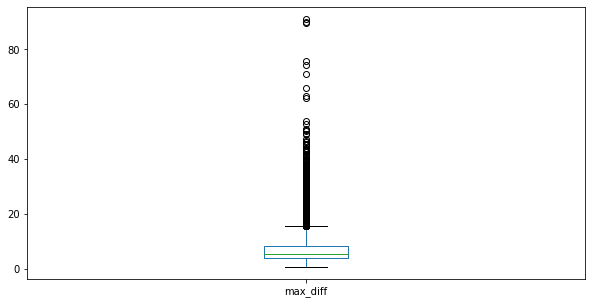

In [11]:
#读取数据

df = pd.read_csv(
    'D:/pycharm/DDA/IF8888_5.CCFX.csv', sep=',',  parse_dates=True, index_col = "dates")# skiprows=lambda x: x>0 and x%5 != 0, index_col = "dates")
df = df.iloc[:, 0:6]
#选取日期
df = df[df['date']<='2011-07-20']

df = baoluoxian(df,50,200)
df = up_down_max(df,50,200,26,7)

print(df['max_diff'].describe())
#画图
fig, ax = plt.subplots(figsize=(10,5))
df[df['date']<='2011.07.20']['max_diff'].plot(kind='box', ax=ax)


In [19]:
df_signal = calc_signal(df, 200,26, 7, 5, default_af=0.02 , stepsize_af=0.02, max_af=0.2)
df_position = calc_position(df_signal, shift_period=1, otime_limit=None, etime_limit=None)

In [22]:
df_my_data, performance_df = statistic_performance(df_position, 
                                                   is_consider_open=False, 
                                                   is_daily_close=False,
                                                   comm=0.0002)

print(performance_df)
# df_my_data.query("hold_cumu_r<-0.1")

# df_my_data.to_csv('2_1.csv', index=False)
visualize_performance(df_my_data)

                0
累计收益       13.09%
多仓次数          245
多仓成功次数         63
多仓胜率       25.71%
多仓平均持有期      6.29
空仓次数          251
空仓成功次数         79
空仓胜率       31.47%
空仓平均持有期      0.31
周期胜率       45.52%
最大回撤        4.56%
年化收益/最大回撤    2.25
年化收益       10.25%
年化标准差       9.28%
年化夏普         1.10
